In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfds.disable_progress_bar()

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
dataset, dataset_info = tfds.load('stanford_dogs', as_supervised = True, with_info = True)

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteD2ETJK/stanford_dogs-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteD2ETJK/stanford_dogs-test.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet
ERROR:absl:Statistics generation doesn't work for nested structures yet


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [4]:
print('dataset has type:', type(dataset))
print('\nThe keys of dataset are:', list(dataset.keys()))
training_set, testing_set = dataset['train'], dataset['test']

dataset has type: <class 'dict'>

The keys of dataset are: ['test', 'train']


In [5]:
num_training_examples = dataset_info.splits['train'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples

num_classes = dataset_info.features['label'].num_classes

print('There are {:,} classes in our dataset'.format(num_classes))

print('\nThere are {:,} images in the test set'.format(num_test_examples))
print('There are {:,} images in the training set'.format(num_training_examples))

There are 120 classes in our dataset

There are 8,580 images in the test set
There are 12,000 images in the training set


In [6]:
shape_images = dataset_info.features['image'].shape

for image, label in training_set.take(3):
    image = image.numpy().squeeze()
    label = label.numpy()
    print('The label of this image is:', label)

print('\nThe images in our dataset have shape:', shape_images)

The label of this image is: 36
The label of this image is: 118
The label of this image is: 46

The images in our dataset have shape: (None, None, 3)


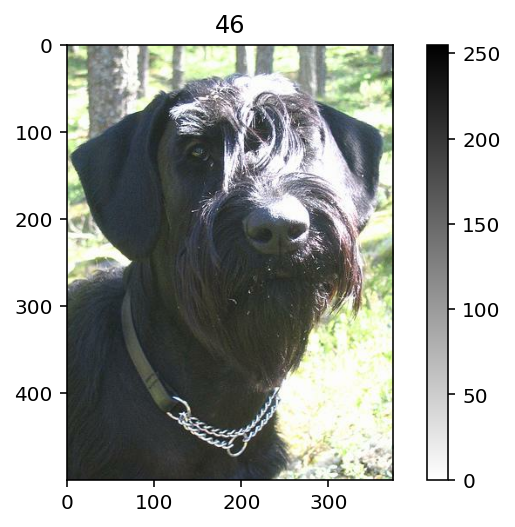

In [7]:
plt.imshow(image, cmap= plt.cm.binary)
plt.colorbar()
plt.title(label)
plt.show()

In [8]:
batch_size = 32
image_size = 224

image_gen_train = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 45,
                                     width_shift_range = 0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

training_batches = training_set.cache().shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
testing_batches = testing_set.map(format_image).batch(batch_size).prefetch(1)

In [9]:
URL = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

In [10]:
feature_extractor.trainable = False

In [11]:
dropout_rate = 0.2

model3 = tf.keras.Sequential()

model3.add(feature_extractor)

#for neurons in layer_neurons:
#    model.add(tf.keras.layers.Dense(neurons, activation = 'relu'))
#    model.add(tf.keras.layers.Dropout(dropout_rate))

model3.add(tf.keras.layers.Dense(120, activation = 'softmax'))

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,810,680
Trainable params: 245,880
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
model3.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [13]:
with tf.device('/GPU:0'):
    EPOCHS = 10

    history = model3.fit(training_batches,
                        epochs=EPOCHS)

Epoch 1/10
375/375 [==============================] - 30s 81ms/step - loss: 1.4721 - accuracy: 0.6175
Epoch 2/10
375/375 [==============================] - 29s 79ms/step - loss: 0.5472 - accuracy: 0.8288
Epoch 3/10
375/375 [==============================] - 30s 80ms/step - loss: 0.3271 - accuracy: 0.9006
Epoch 4/10
375/375 [==============================] - 30s 80ms/step - loss: 0.2060 - accuracy: 0.9463
Epoch 5/10
375/375 [==============================] - 30s 81ms/step - loss: 0.1388 - accuracy: 0.9693
Epoch 6/10
375/375 [==============================] - 30s 81ms/step - loss: 0.0952 - accuracy: 0.9843
Epoch 7/10
375/375 [==============================] - 30s 81ms/step - loss: 0.0723 - accuracy: 0.9894
Epoch 8/10
375/375 [==============================] - 31s 82ms/step - loss: 0.0536 - accuracy: 0.9938
Epoch 9/10
375/375 [==============================] - 31s 82ms/step - loss: 0.0441 - accuracy: 0.9952
Epoch 10/10
375/375 [==============================] - 31s 83ms/step - loss: 0.036

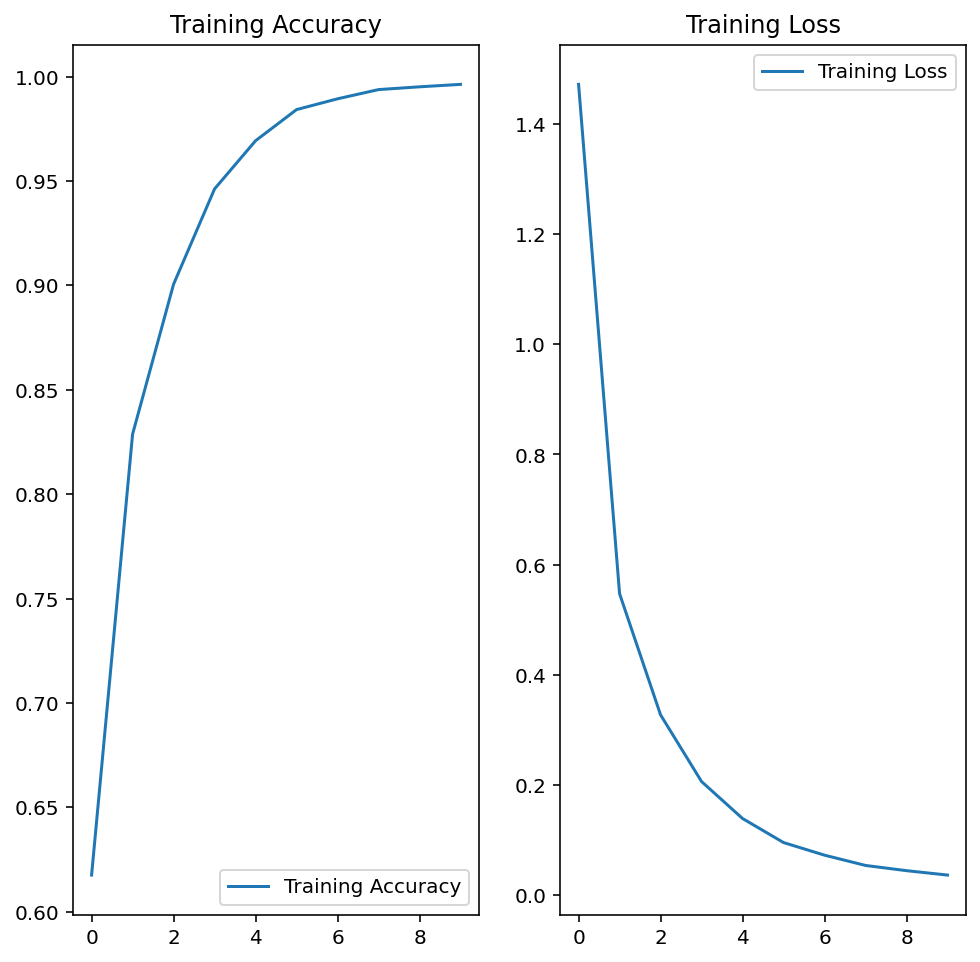

In [14]:
training_accuracy = history.history['accuracy']

training_loss = history.history['loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [15]:
loss, accuracy = model3.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

269/269 [==============================] - 22s 83ms/step - loss: 1.0724 - accuracy: 0.7443

Loss on the TEST Set: 1.072
Accuracy on the TEST Set: 74.429%
